# Example 11 - Multi-objective optimization for plug flow reactor

In example 7, we demonstrated how Bayesian Optimization can perform multi-objective optimization (MOO) and create a Pareto front using weighted objectives. In this example, we will demonstrate using the other acquisition function, Expected Hypervolume Improvement, to perform the MOO. We will use the same PFR model. Two output variables will be generated from the model: yield (`y1`) and selectivity (`y2`). Unfortunately, these two variables cannot be maximized simultaneously. An increase in yield would lead to a decrease in selectivity, and vice versa. 

The details of this example is summarized in the table below:

| Key Item      | Description |
| :----------------- | :----------------- |
| Goal | Maximization, two objectives |
| Objective function | PFR model |
| Input (X) dimension | 3 |
| Output (Y) dimension | 2 |
| Analytical form available? | Yes |
| Acqucision function | q-Expected Hypervolume improvement (qEHVI) |
| Initial Sampling | Latin hypercube | 

Next, we will go through each step in Bayesian Optimization.

## 1. Import `nextorch` and other packages

## 2. Define the objective function and the design space
We import the PFR model, and wrap it in a Python function called `PFR` as the objective function `objective_func`. 

The ranges of the input X are specified. 

In [1]:
import os
import sys
import time
from IPython.display import display

project_path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, project_path)

# Set the path for objective function
objective_path = os.path.join(project_path, 'examples', 'PFR')
sys.path.insert(0, objective_path)

import numpy as np
from nextorch import plotting, bo, doe, utils, io

In [2]:
#%% Define the objective function
from fructose_pfr_model_function import Reactor

def PFR(X_real):
    """PFR model

    Parameters
    ----------
    X_real : numpy matrix
        reactor parameters: 
        T, pH and tf in real scales

    Returns
    -------
    Y_real: numpy matrix
        reactor yield and selectivity
    """
    if len(X_real.shape) < 2:
        X_real = np.expand_dims(X_real, axis=1) #If 1D, make it 2D array
        
    Y_real = []
    for i, xi in enumerate(X_real):
        Conditions = {'T_degC (C)': xi[0], 'pH': xi[1], 'tf (min)' : 10**xi[2]}
        yi = Reactor(**Conditions)        
        Y_real.append(yi)
            
    Y_real = np.array(Y_real)
        
    return Y_real # yield, selectivity


# Objective function
objective_func = PFR


#%% Define the design space
# Three input temperature C, pH, log10(residence time)
X_name_list = ['T', 'pH', r'$\rm log_{10}(tf_{min})$']
X_units = [r'$\rm ^{o}C $', '', '']

# Add the units
X_name_with_unit = []
for i, var in enumerate(X_name_list):
    if not X_units[i]  == '':
        var = var + ' ('+ X_units[i] + ')'
    X_name_with_unit.append(var)
    
# two outputs
Y_name_with_unit = ['Yield %', 'Selectivity %']

# combine X and Y names
var_names = X_name_with_unit + Y_name_with_unit

# Set the operating range for each parameter
X_ranges =  [[140, 200], # Temperature ranges from 140-200 degree C
             [0, 1], # pH values ranges from 0-1 
             [-2, 2]] # log10(residence time) ranges from -2-2  


# Get the information of the design space
n_dim = len(X_name_list) # the dimension of inputs
n_objective = len(Y_name_with_unit) # the dimension of outputs

## 3. Define the initial sampling plan
Here we use LHC design with 10 points for the initial sampling. The initial reponse in a real scale `Y_init_real` is computed from the objective function.

/Users/tyc/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ode.py:1179: UserWarning: dopri5: larger nsteps is needed
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


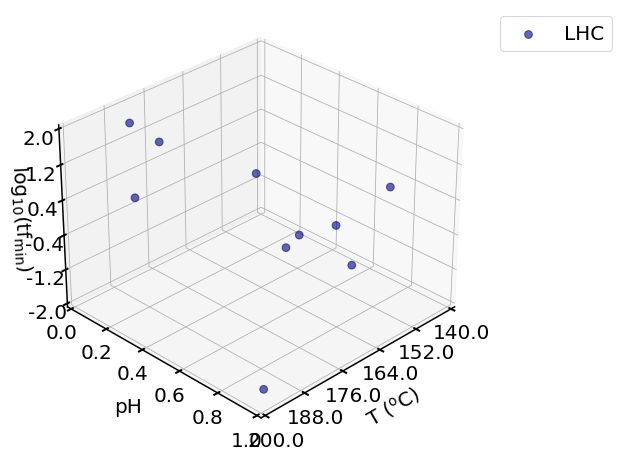

In [3]:
#%% Initial Sampling 
# Latin hypercube design with 10 initial points
n_init_lhc = 10
X_init_lhc = doe.latin_hypercube(n_dim = n_dim, n_points = n_init_lhc, seed= 1)
# Get the initial responses
Y_init_lhc = bo.eval_objective_func(X_init_lhc, X_ranges, objective_func)

# Compare the two sampling plans
plotting.sampling_3d(X_init_lhc, 
                     X_names = X_name_with_unit,
                     X_ranges = X_ranges,
                     design_names = 'LHC')

## 4. Initialize an `Experiment` object 

In this example, we use an `EHVIMOOExperiment` object, a class designed for multi-objective optimization using `Expected Hypervolume Improvement` as aquisition funciton. It can handle multiple weight combinations, perform the scalarized objective optimization automatically, and construct the entire Pareto front. 

An `EHVIMOOExperiment` is a subclass of `Experiment`. It requires all key components as `Experiment`. Additionally, `ref_point` is required for `EHVIMOOExperiment.set_ref_point` function. It defines a list of values that are slightly worse than the lower bound of objective values, where the lower bound is the minimum acceptable value of interest for each objective. 

In [4]:
#%% Initialize an multi-objective Experiment object
# Set its name, the files will be saved under the folder with the same name
Exp_lhc = bo.EHVIMOOExperiment('PFR_yield_MOO')  
# Import the initial data
Exp_lhc.input_data(X_init_lhc, 
                   Y_init_lhc, 
                   X_ranges = X_ranges, 
                   X_names = X_name_with_unit,
                   Y_names = Y_name_with_unit,
                   unit_flag = True)

# Set the optimization specifications 
# here we set the reference point
ref_point = [10.0, 10.0]

Exp_lhc.set_ref_point(ref_point)
Exp_lhc.set_optim_specs(objective_func = objective_func, 
                        maximize = True)

Iter 10/100: 5.538654327392578
Iter 20/100: 5.13447380065918
Iter 30/100: 4.929288387298584
Iter 40/100: 4.781908988952637


## 5. Run trials 

`EHVIMOOExperiment.run_trials_auto` can run these tasks automatically by specifying the acqucision function, Expected Hypervolume Improvement (`qEHVI`). In this way, we generate one point per iteration in default. Alternatively, we can manually specify the number of next points we would like to obtain.

Some progress status will be printed out during the training.

In [5]:
# Set the number of iterations for each experiments
n_trials_lhc = 30 

# run trials
# Exp_lhc.run_trials_auto(n_trials_lhc, 'qEHVI')

for i in range(n_trials_lhc):
    # Generate the next experiment point
    X_new, X_new_real, acq_func = Exp_lhc.generate_next_point(n_candidates=4)
    # Get the reponse at this point
    Y_new_real = objective_func(X_new_real) 
    # or 
    # Y_new_real = bo.eval_objective_func(X_new, X_ranges, objective_func)

    # Retrain the model by input the next point into Exp object
    Exp_lhc.run_trial(X_new, X_new_real, Y_new_real)

end_time = time.time()

Iter 10/100: 3.9824819564819336
Iter 10/100: 3.403203010559082
Iter 10/100: 3.140371799468994
Iter 10/100: 2.8846397399902344
Iter 10/100: 2.5103049278259277
Iter 10/100: 2.448652744293213


/Users/tyc/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ode.py:1179: UserWarning: dopri5: larger nsteps is needed
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Iter 10/100: 2.2202374935150146
Iter 10/100: 2.1436986923217773
Iter 10/100: 1.5269200801849365
Iter 10/100: 1.299017310142517


/Users/tyc/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/_ode.py:1179: UserWarning: dopri5: larger nsteps is needed
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


Iter 10/100: 1.1317164897918701
Iter 10/100: 1.1393492221832275
Iter 10/100: 1.0865610837936401
Iter 10/100: 0.962526798248291
Iter 10/100: 0.9264534711837769
Iter 10/100: 0.8271545171737671
Iter 10/100: 0.7124900817871094
Iter 10/100: 0.5813252925872803
Iter 10/100: 0.483967661857605
Iter 10/100: 0.3973549008369446
Iter 10/100: 0.21081078052520752
Iter 20/100: 0.16223067045211792
Iter 10/100: 0.11483311653137207
Iter 20/100: 0.07105433940887451
Iter 30/100: 0.03855109214782715
Iter 10/100: -0.018623948097229004
Iter 20/100: -0.03811085224151611
Iter 10/100: -0.1709747314453125
Iter 10/100: -0.24976247549057007
Iter 10/100: -0.36525076627731323
Iter 20/100: -0.3675547242164612
Iter 10/100: -0.3635687232017517
Iter 10/100: -0.3858334422111511
Iter 10/100: -0.5145975351333618
Iter 20/100: -0.5159613490104675
Iter 30/100: -0.5162714719772339
Iter 40/100: -0.5163116455078125
Iter 10/100: -0.5725678205490112
Iter 20/100: -0.5742869973182678
Iter 30/100: -0.5748425126075745
Iter 40/100: -0.5

## 6. Visualize the Pareto front
We can get the Pareto set directly from the `EHVIMOOExperiment` object by using `EHVIMOOExperiment.get_optim`.

To visualize the Pareto front, `y1` values are plotted against `y2` values. The region below $ y=x $ is infeasible for the PFR model and we have no Pareto points fall below the line, incidating the method is validate. Besides, all sampling points are shown as well.

,T ($\rm ^{o}C $),pH,$\rm log_{10}(tf_{min})$,Yield %,Selectivity %
0,147.81,0.34,-1.56,2.54,64.76
1,161.23,0.49,-1.04,16.25,62.76
2,196.52,0.30,-1.86,38.35,59.47
3,193.90,0.66,-1.16,47.64,56.42
4,144.40,0.51,-0.41,15.58,62.82
5,141.27,0.97,-0.79,2.00,65.04
6,157.80,0.36,-0.96,19.20,62.36
7,192.33,0.35,-1.64,40.09,59.10
8,161.68,0.71,-0.65,22.88,61.80
9,185.50,0.96,-0.99,32.01,60.50


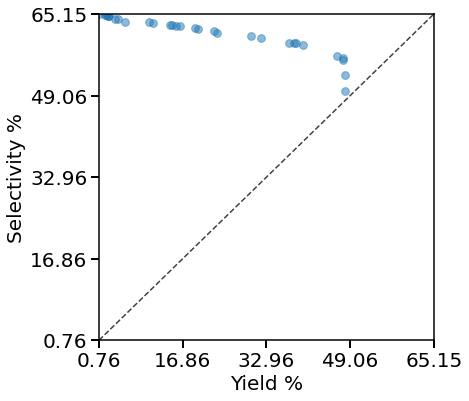

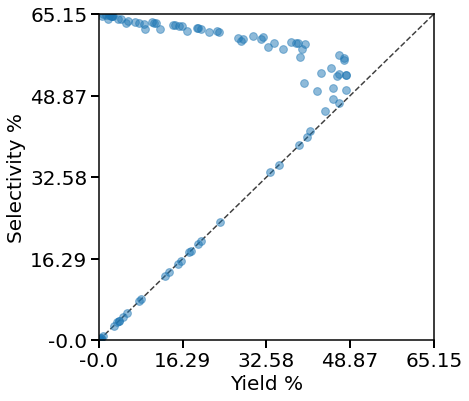

In [6]:
Y_real_opts, X_real_opts = Exp_lhc.get_optim()

# Parse the optimum into a table
data_opt = io.np_to_dataframe([X_real_opts, Y_real_opts], var_names)
display(data_opt.round(decimals=2))

# Make the pareto front
plotting.pareto_front(Y_real_opts[:, 0], Y_real_opts[:, 1], Y_names=Y_name_with_unit, fill=False)

# All sampling points
plotting.pareto_front(Exp_lhc.Y_real[:, 0], Exp_lhc.Y_real[:, 1], Y_names=Y_name_with_unit, fill=False)

## References:
Desir, P.; Saha, B.; Vlachos, D. G. Energy Environ. Sci. 2019.

Swift, T. D.; Bagia, C.; Choudhary, V.; Peklaris, G.; Nikolakis, V.; Vlachos, D. G. ACS Catal. 2014, 4 (1), 259–267

The PFR model can be found on GitHub: https://github.com/VlachosGroup/Fructose-HMF-Model